# X-Ray Diffraction (XRD) Phase Analysis

Training on TOPAS data to beat Madsen et al. 2004 (https://onlinelibrary.wiley.com/iucr/doi/10.1107/S0021889801007476?msockid=3955d955fda66ec51ca2cb9bfca96f5a)

This notebook is a walkthrough of results, post training the model.

## Table of Contents
1. [Setup](#setup)
2. [Data Loading](#data-loading)
3. [Data Visualization](#data-visualization)
4. [Model Analysis](#model-analysis)
5. [Madsen Round Robin Sample Analysis](#madsen-round-robin-sample-analysis)

## Setup

First, set the working directories and import required libraries.

In [90]:
# Set the working directory to the base of the repo
base_dir = '/monfs01/projects/ys68/XRD_phase_analysis'

# All the data folders
data_dirs = [
    'training_data/processed_data_p1',
    'training_data/processed_data_p2',
    'training_data/processed_data_p3',
    'training_data/processed_data_p4',
    'training_data/processed_data_p5',
    'training_data/processed_data_p6',
    'training_data/processed_data_p7',
    'training_data/processed_data_p8',
    'training_data/processed_data_p9',
    'training_data/processed_data_p10',
    'training_data/processed_data_p11'
]

In [91]:
import os
import math
import json
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from matplotlib.gridspec import GridSpec

# Set the working directory to the base of the repo 
os.chdir(base_dir)
from src.data_loading.TOPASXRD_data_loader import create_data_loaders

%matplotlib inline
plt.style.use('seaborn-v0_8')

## Data Loading

Now we'll load the simulated TOPAS XRD data, including intensities, weight fractions, additional parameters and metadata.

In [92]:
# Initialize lists to store data
all_intensities = []
all_weight_fractions = []
all_params = []
all_metadata = []

# Load data from each directory
for data_dir in data_dirs:
    full_path = os.path.join(base_dir, data_dir)
    
    # Load intensities
    intensities_temp = np.load(os.path.join(full_path, 'intensities.npy'))
    all_intensities.append(intensities_temp)
    
    # Load weight fractions
    weight_fractions_temp = pd.read_csv(os.path.join(full_path, 'weight_fractions.csv'))
    all_weight_fractions.append(weight_fractions_temp)
    
    # Load additional parameters
    params_temp = pd.read_csv(os.path.join(full_path, 'all_params.csv'))
    all_params.append(params_temp)
    
    # Load metadata
    with open(os.path.join(full_path, 'metadata.json'), 'r') as f:
        all_metadata.append(json.load(f))

# Combine data
intensities = np.concatenate(all_intensities, axis=0)
weight_fractions = pd.concat(all_weight_fractions, ignore_index=True)
additional_params = pd.concat(all_params, ignore_index=True)
metadata = all_metadata  # Keep as list if structure needed

print(f"Loaded {len(intensities)} XRD patterns")
print(f"Shape of intensities array: {intensities.shape}")

Loaded 71944 XRD patterns
Shape of intensities array: (71944, 7250)


## Data Visualization

### Display Random XRD Simulations

Let's visualize some random XRD simulations to get a feel for our data.

In [93]:
# TODO: 2 theta to degrees instead of index
# TODO: Add additional params?

# Create a fixed color map for all phases
all_phases = weight_fractions.columns.tolist()
color_palette = dict(zip(all_phases, sns.color_palette("viridis", len(all_phases))))

def plot_xrd_pattern(intensity, index, weight_fractions, additional_params, title=None):
    # Set up the matplotlib figure
    fig = plt.figure(figsize=(15, 10))
    gs = GridSpec(2, 2, width_ratios=[3, 1], height_ratios=[3, 1])
    
    # Plot XRD pattern
    ax_main = fig.add_subplot(gs[0, 0])
    two_theta = np.arange(5, 150, 0.02)  # Creates array from 5 to 150 with 0.02 steps
    ax_main.plot(two_theta, intensity, color='navy')
    ax_main.set_xlabel('2θ (degrees)', fontsize=12)
    ax_main.set_ylabel('Intensity', fontsize=12)
    if title:
        ax_main.set_title(title, fontsize=16)
    
    # Plot weight fractions as a horizontal bar chart
    ax_weight = fig.add_subplot(gs[0, 1])
    
    # Create a DataFrame with all phases, filling missing values with 0
    weight_df = pd.DataFrame({'Phase': all_phases, 
                              'Percentage': [weight_fractions.loc[index, phase] if phase in weight_fractions.columns else 0 
                                             for phase in all_phases]})
    
    # Sort by the global order of phases
    weight_df['Phase'] = pd.Categorical(weight_df['Phase'], categories=all_phases, ordered=True)
    weight_df = weight_df.sort_values('Phase')
    
    # Plot the bar chart
    sns.barplot(data=weight_df, x='Percentage', y='Phase', ax=ax_weight, hue='Phase', palette=color_palette, dodge=False, legend=False)     
    ax_weight.set_title('Weight Fractions', fontsize=14)
    ax_weight.set_xlabel('Percentage', fontsize=12)
    ax_weight.set_xlim(0, 1)
    
    plt.tight_layout()
    plt.show()

Plot x random XRD patterns with phase information.

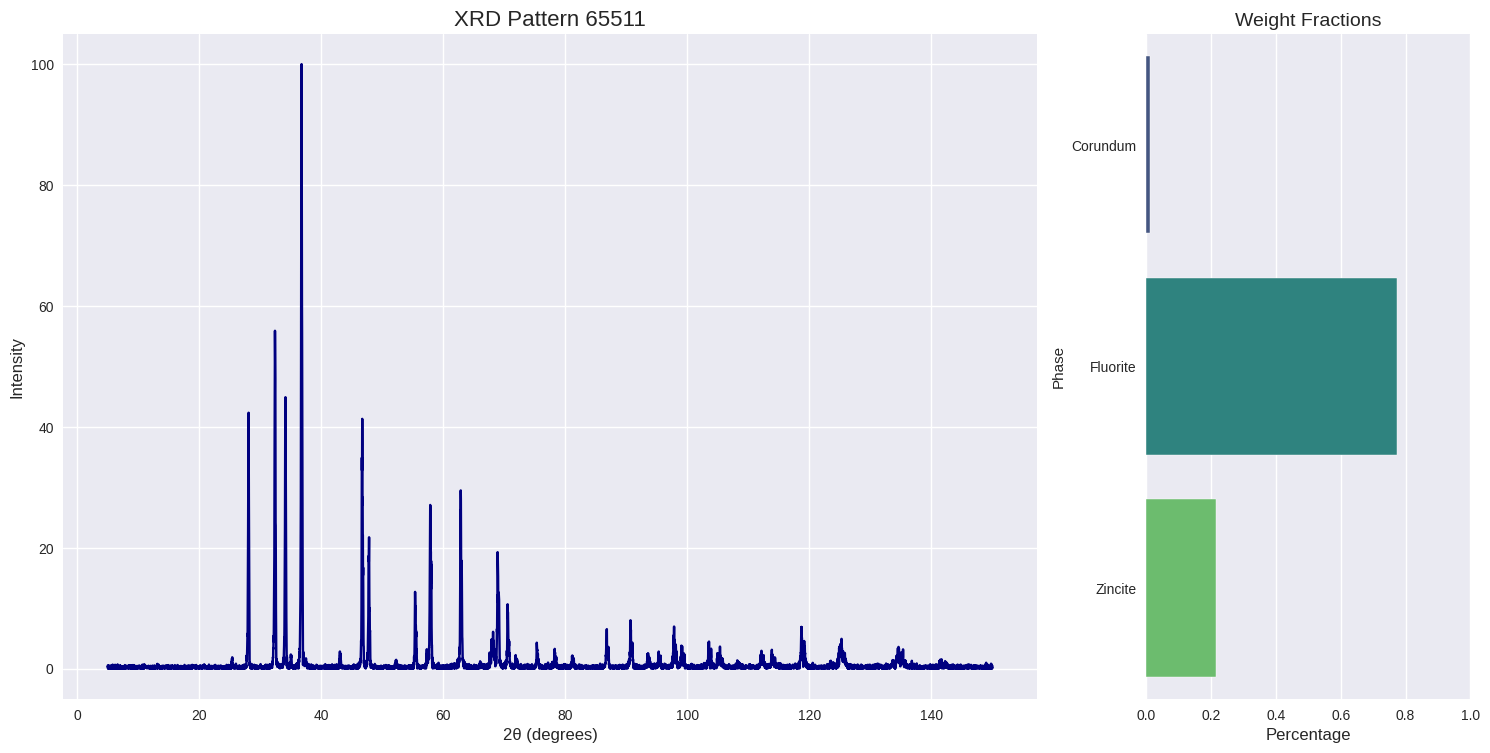

In [94]:
plot_amount = 1

for i in range(plot_amount):
    random_index = np.random.randint(0, len(intensities))
    plot_xrd_pattern(intensities[random_index], random_index, weight_fractions, additional_params, 
                     f"XRD Pattern {random_index}")

### Analyze Weight Fraction Distributions

Now let's examine the distributions of randomized weight fractions for each phase.

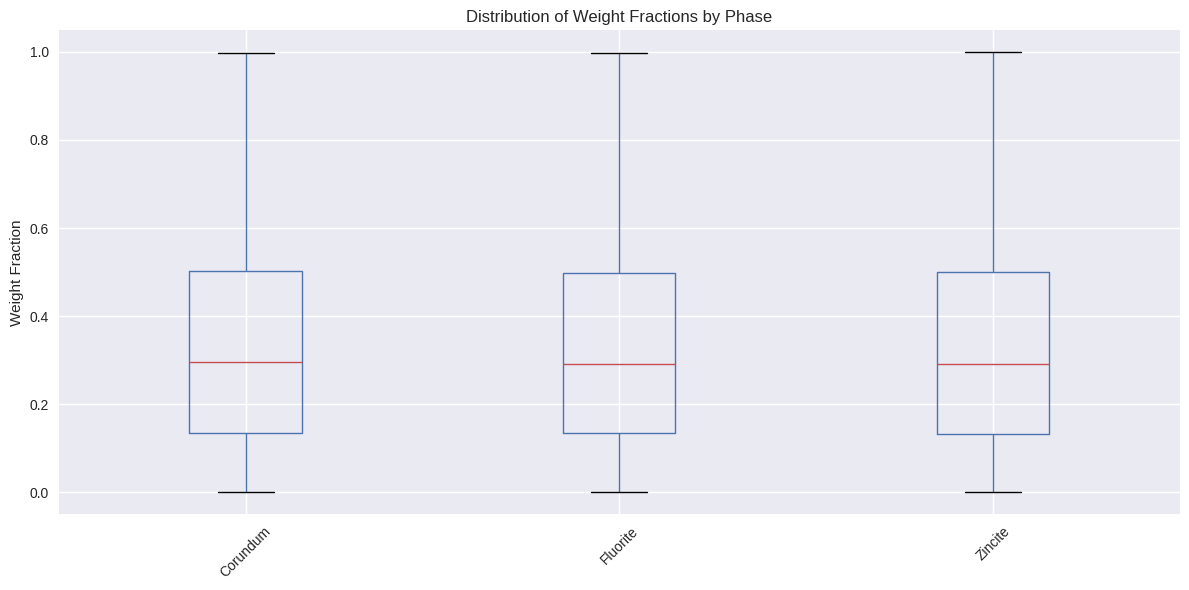

Average weight fractions:
Corundum    0.334719
Fluorite    0.332023
Zincite     0.333259
dtype: float64


In [95]:
plt.figure(figsize=(12, 6))
weight_fractions.boxplot()
plt.title('Distribution of Weight Fractions by Phase')
plt.ylabel('Weight Fraction')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate and print average weight fractions
avg_weight_fractions = weight_fractions.mean()
print("Average weight fractions:")
print(avg_weight_fractions)

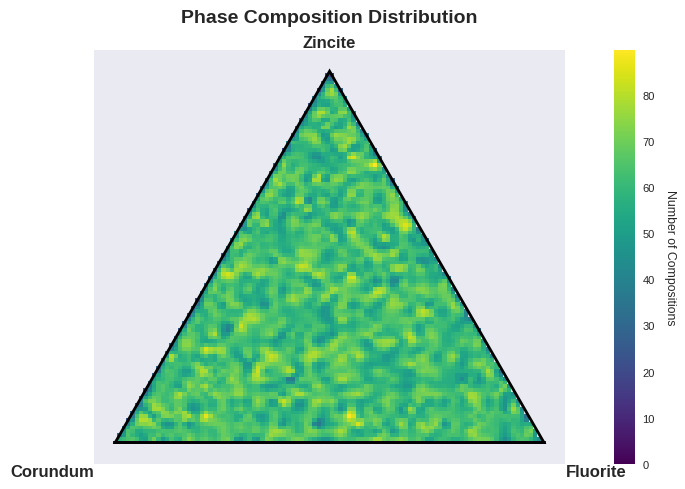

In [96]:
def analyze_phase_distributions(weight_fractions, output_dir=None, dpi=300, nbins=100):
    """
    Comprehensive analysis of phase weight fraction distributions using smoothed interpolation.
    """
    # Set style for publication-quality plots
    plt.style.use('seaborn-v0_8-paper')
    
    # Create figure
    fig = plt.figure(figsize=(10, 5))
    ax_tri = plt.gca()
    
    # Convert to barycentric coordinates
    points = weight_fractions.values
    
    # Convert barycentric to cartesian coordinates
    cart_coords = np.zeros((len(points), 2))
    for i, point in enumerate(points):
        cart_coords[i,0] = 0.5 * (2 * point[1] + point[2])  # x coordinate
        cart_coords[i,1] = np.sqrt(3)/2 * point[2]          # y coordinate
    
    x = cart_coords[:,0]
    y = cart_coords[:,1]
    
    # Create a fine mesh for interpolation
    xi = np.linspace(0, 1, nbins)
    yi = np.linspace(0, np.sqrt(3)/2, nbins)
    xi_mg, yi_mg = np.meshgrid(xi, yi)
    
    # Calculate point density using histogram
    H, xedges, yedges = np.histogram2d(x, y, bins=nbins//2,
                                      range=[[0, 1], [0, np.sqrt(3)/2]])
    
    # Get the centers of the histogram bins
    x_centers = (xedges[:-1] + xedges[1:]) / 2
    y_centers = (yedges[:-1] + yedges[1:]) / 2
    xc_mg, yc_mg = np.meshgrid(x_centers, y_centers)
    
    # Interpolate the histogram values onto the fine mesh
    zi = griddata((xc_mg.flatten(), yc_mg.flatten()), 
                 H.T.flatten(),
                 (xi_mg, yi_mg),
                 method='cubic',
                 fill_value=0)
    
    # Create mask for points inside triangle
    def in_triangle(points):
        x, y = points[:, 0], points[:, 1]
        # Three line equations for triangle sides
        c1 = y >= 0  # Bottom line
        c2 = y <= -np.sqrt(3) * (x - 1)  # Right line
        c3 = y <= np.sqrt(3) * x  # Left line
        return c1 & c2 & c3
    
    # Create and apply mask
    points_mg = np.column_stack((xi_mg.flatten(), yi_mg.flatten()))
    mask = in_triangle(points_mg).reshape(xi_mg.shape)
    zi_masked = np.ma.masked_array(zi, ~mask)
    
    # Plot interpolated density with mask
    im = ax_tri.pcolormesh(xi, yi, zi_masked, cmap='viridis', shading='auto')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax_tri)
    cbar.set_label('Number of Compositions', rotation=270, labelpad=15)
    
    # Plot triangle boundary
    triangle = plt.Polygon([[0,0], [1,0], [0.5, np.sqrt(3)/2]], 
                         fill=False, color='black', linewidth=2)
    ax_tri.add_patch(triangle)
    
    # Add labels at vertices
    label_offset = 0.05
    ax_tri.text(-label_offset, -label_offset, 'Corundum', ha='right', va='top', fontsize=12, fontweight='bold')
    ax_tri.text(1 + label_offset, -label_offset, 'Fluorite', ha='left', va='top', fontsize=12, fontweight='bold')
    ax_tri.text(0.5, np.sqrt(3)/2 + label_offset, 'Zincite', ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # Set limits exactly to triangle bounds with small padding
    padding = 0.05
    ax_tri.set_xlim(-padding, 1 + padding)
    ax_tri.set_ylim(-padding, (np.sqrt(3)/2) + padding)
    
    ax_tri.set_aspect('equal')
    ax_tri.set_title('Phase Composition Distribution', pad=20, fontsize=14, fontweight='bold')
    ax_tri.set_xticks([])
    ax_tri.set_yticks([])
    
    plt.tight_layout()
    
    return fig

# Usage:
fig = analyze_phase_distributions(weight_fractions)
plt.show()

In [97]:
# TODO: Visualise the distribution of the other parameters.

## Model Analysis

In this section, we'll load a pre-trained model and analyze its performance on a simulated test set.

### Load the Model

Choose a model to load.

In [98]:
%%capture

# Import models you want to use
from src.models.smallFCN import smallFCN
from src.models.MLP import MLP, MLP2, MLP3, MLP4, MLP5, MLP7

model_base_dir = 'trained_models/'

# Choose which model to load and its type
# MLP_mae_0.0190_20241103_180100.pth
# MLP_mae_0.0187_20241103_190319.pth
# best_model_mlp.pth
# model_path = model_base_dir + 'MLP_mae_0.0187_20241103_190319.pth'
# model = MLP()
# model_path = 'trained_models/smallFCN_mae_0.1933_20241010_232729.pth'
# MLP2_mae_0.0163_20241103_233042.pth
# model_path = model_base_dir + 'MLP2_mae_0.0164_20241104_001511.pth'
# model_path = model_base_dir + 'MLP2_mae_0.0163_20241103_233042.pth'
# model = MLP2()
# model_path = model_base_dir + 'MLP3_mae_0.01121691_20241105_204443.pth'
# model = MLP3()
# model_path = model_base_dir + 'MLP4_mae_0.00934758_20241105_210219.pth'
# model = MLP4()
model_path = model_base_dir + 'MLP7_mae_0.00851664_20241105_215133.pth'
model = MLP7()


# Inference params
batch_size = 32 
num_workers = 6

In [99]:
# Set up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model with correct map_location
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
model = model.to(device)

# Create data loaders
train_loader, val_loader, test_loader = create_data_loaders(
    data_dirs,
    batch_size,
    num_workers
)

# Perform inference on the test set
all_predictions = []
all_targets = []

with torch.no_grad():
    for data, target, _ in test_loader: # TODO: Changed from test
        # data = data.unsqueeze(1).to(device) #TODO: MLP doesn't need this 
        output = model(data)
        all_predictions.append(output.cpu().numpy())
        all_targets.append(target.numpy())

predictions = np.concatenate(all_predictions)
targets = np.concatenate(all_targets)

/tmp/ipykernel_138326/2396359749.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


### Visualize Predictions vs Actual Weights

Let's compare the model's predictions against the actual weight fractions for each phase in the test set.

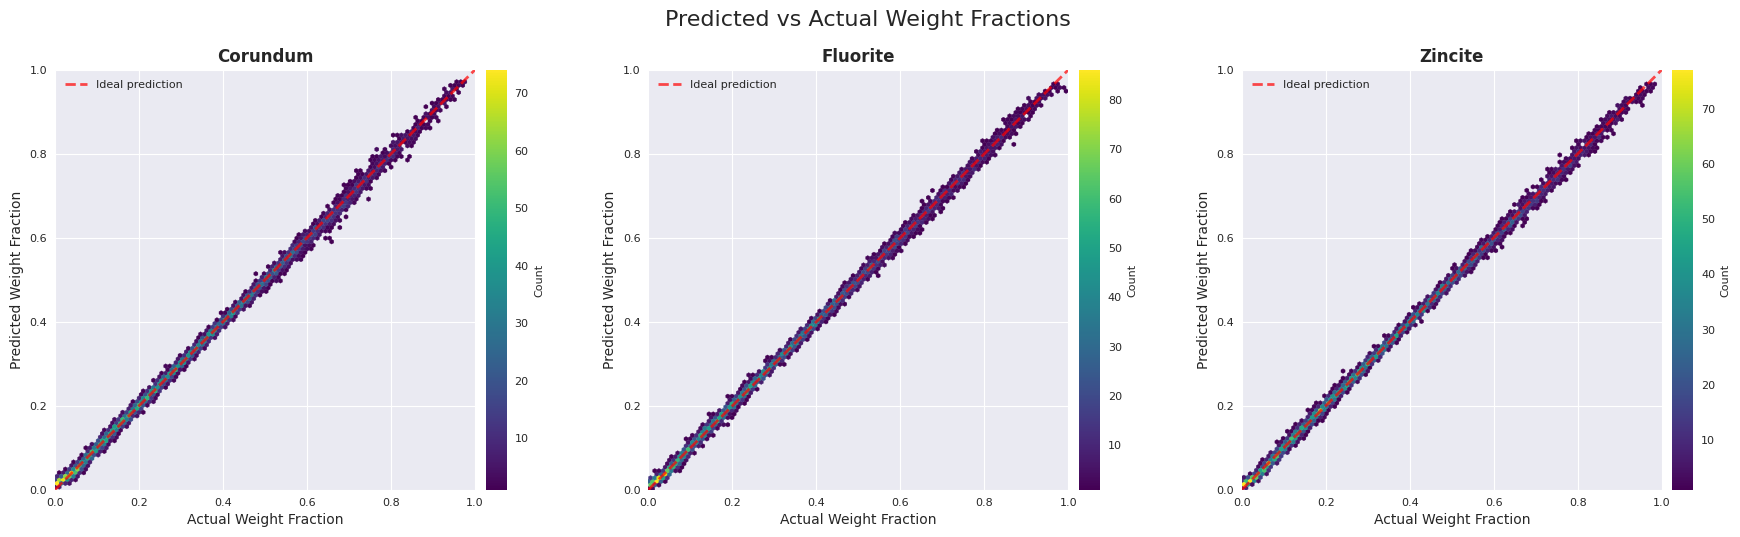

In [100]:
def plot_predictions_vs_actual(predictions, targets, phase_names):
    n_phases = predictions.shape[1]
    
    # Calculate the number of rows and columns for the subplots
    n_cols = min(3, n_phases)  # Maximum 3 plots per row
    n_rows = math.ceil(n_phases / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    fig.suptitle('Predicted vs Actual Weight Fractions', fontsize=16, y=1.02)
    
    # Set a clean, modern style
    sns.set_style("whitegrid")
    
    # Flatten the axes array if it's 2D
    if n_rows > 1:
        axes = axes.flatten()
    
    for i, (ax, phase) in enumerate(zip(axes, phase_names)):
        # Create a hexbin plot for density
        hb = ax.hexbin(targets[:, i], predictions[:, i], gridsize=100, cmap='viridis', mincnt=1)
        
        # Plot the diagonal line
        ax.plot([0, 1], [0, 1], 'r--', linewidth=2, alpha=0.7, label='Ideal prediction')
        
        # Set labels and title
        ax.set_xlabel('Actual Weight Fraction', fontsize=10)
        ax.set_ylabel('Predicted Weight Fraction', fontsize=10)
        ax.set_title(f'{phase}', fontsize=12, fontweight='bold')
        
        # Set limits and aspect
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_aspect('equal', adjustable='box')
        
        # Add a colorbar
        cb = plt.colorbar(hb, ax=ax, pad=0.02)
        cb.set_label('Count', fontsize=8)
        
        # Add legend
        ax.legend(loc='upper left', fontsize=8)
        
        # Adjust tick label size
        ax.tick_params(axis='both', which='major', labelsize=8)
    
    # Remove any unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

# Get phase names from the weight_fractions DataFrame
phase_names = weight_fractions.columns.tolist()

# Plot predictions vs actual values
plot_predictions_vs_actual(predictions, targets, phase_names)

In [101]:
# TODO: Do some more analysis

## Madsen Round Robin Sample Analysis

Load the Round Robin Samples and their associated data.


In [112]:
# Function to load and process XY files
def load_xy_file(file_path):
    data = np.loadtxt(file_path, skiprows=1)
    intensities = data[:, 1]  # Second column contains intensities
    # Normalize intensities to 100
    intensities = (intensities / np.max(intensities)) * 100
    return intensities

# Load and process XY files
sample_dir = 'analysis/Madsen_Round_Robin_2004/samples'
xy_files = [f for f in os.listdir(sample_dir) if f.endswith('.xy')]
xy_files.sort()  # Sort alphabetically to match weight_fractions.csv

intensities = []
for file in xy_files:
    intensity = load_xy_file(os.path.join(sample_dir, file))
    intensities.append(intensity)

# Convert to numpy array and reshape for the model
intensities = np.array(intensities)
intensities = intensities.reshape(intensities.shape[0], 1, -1)  # Add channel dimension

# Convert to torch tensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
intensities_tensor = torch.FloatTensor(intensities).to(device)

# Perform inference
model.eval()
with torch.no_grad():
    predictions = model(intensities_tensor)

# Convert predictions to numpy array
predictions = predictions.cpu().numpy()

# Load weight fractions
weight_fractions = pd.read_csv('analysis/Madsen_Round_Robin_2004/weight_fractions.csv')

# Load participant data
participant_data = {
    method: pd.read_csv(f'analysis/Madsen_Round_Robin_2004/{method}_weight_fractions.csv')
    for method in ['CPD_analysis', 'X-ray', 'Neutron', 'Synchrotron']
}

def cum_error(true_values, predicted_values):
    """Calculate cum error across all phases for a single sample"""
    return np.mean(np.sqrt((true_values - predicted_values)**2)*100)

In [103]:
# Load the statistics data
stats_df = pd.read_csv('/home/jsprigg/ys68/XRD_phase_analysis/analysis/Madsen_Round_Robin_2004/stats.csv')
stats_df['sample'] = stats_df['sample'].astype(str)

/tmp/ipykernel_138326/696987687.py:266: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x='', y='Method', data=df, ax=ax_phase,
/tmp/ipykernel_138326/696987687.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)
/tmp/ipykernel_138326/696987687.py:266: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x='', y='Method', data=df, ax=ax_phase,
/tmp/ipykernel_138326/696987687.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)
/tmp/ipykernel_138326/696987687.py:266: 

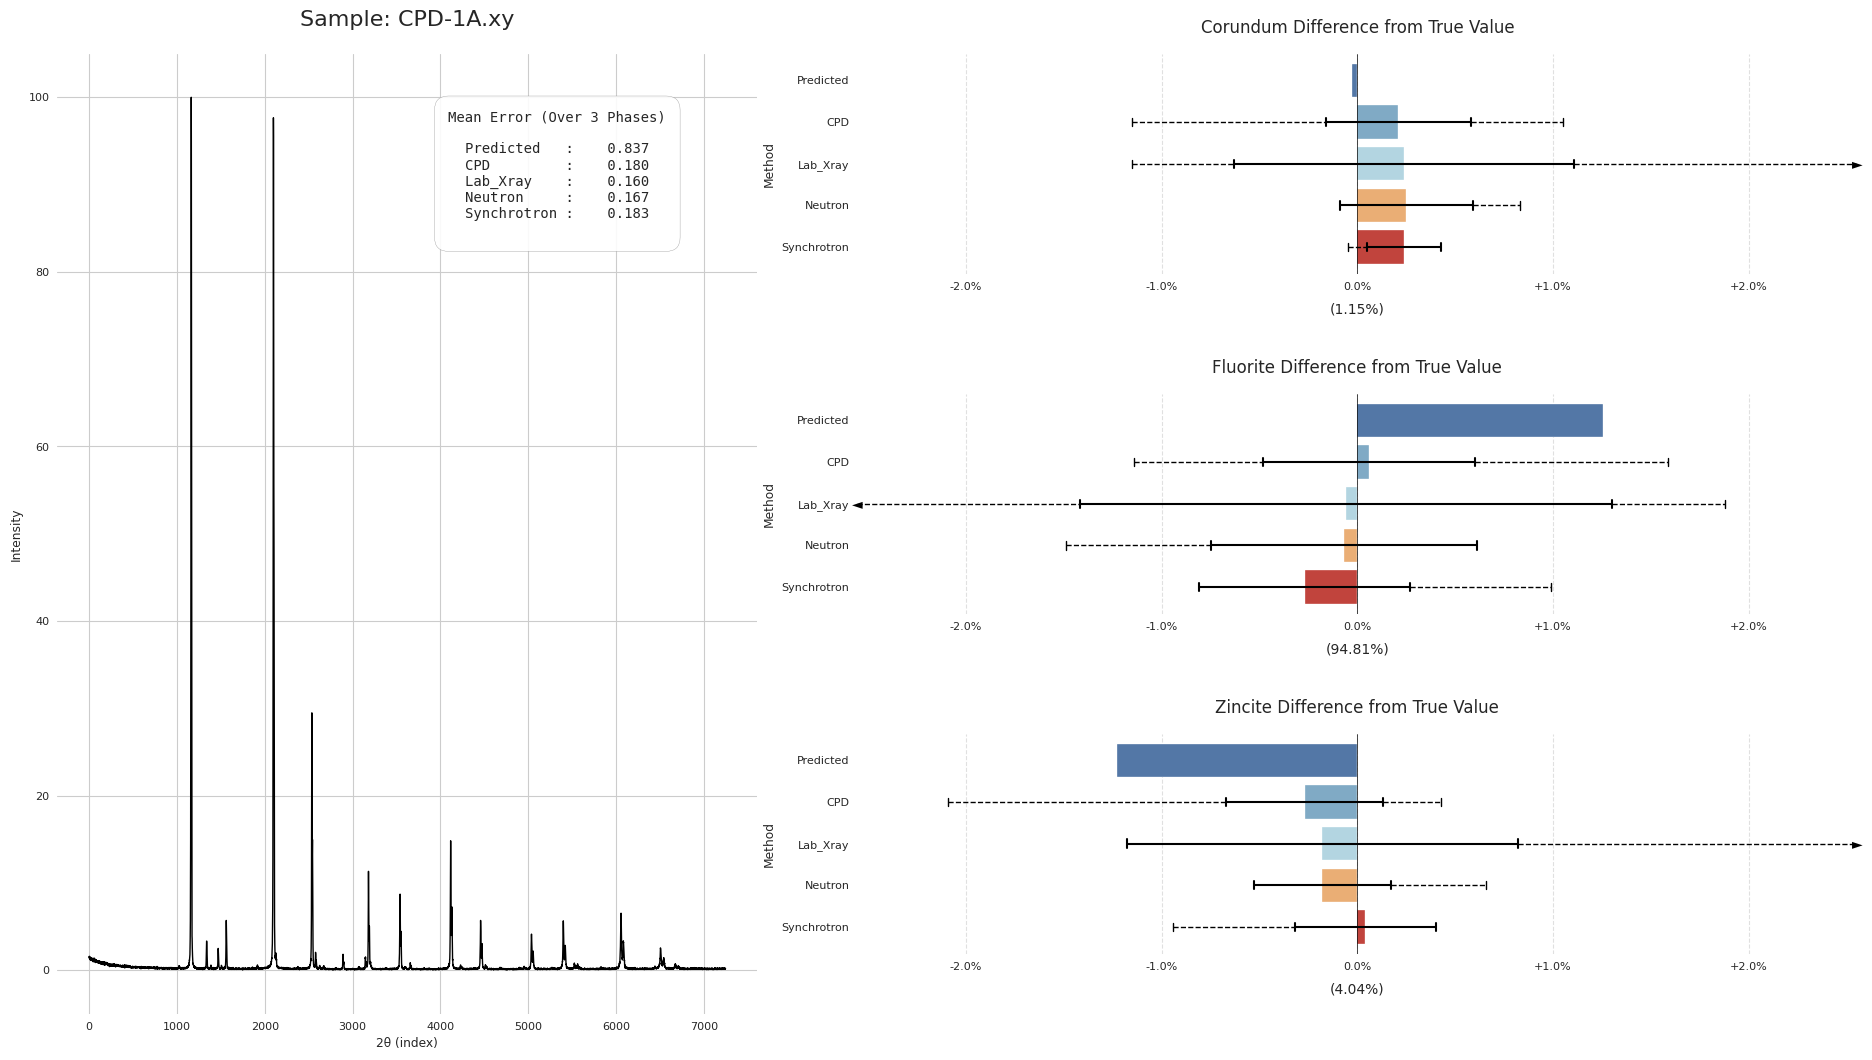

/tmp/ipykernel_138326/696987687.py:266: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x='', y='Method', data=df, ax=ax_phase,
/tmp/ipykernel_138326/696987687.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)
/tmp/ipykernel_138326/696987687.py:266: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x='', y='Method', data=df, ax=ax_phase,
/tmp/ipykernel_138326/696987687.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)
/tmp/ipykernel_138326/696987687.py:266: 

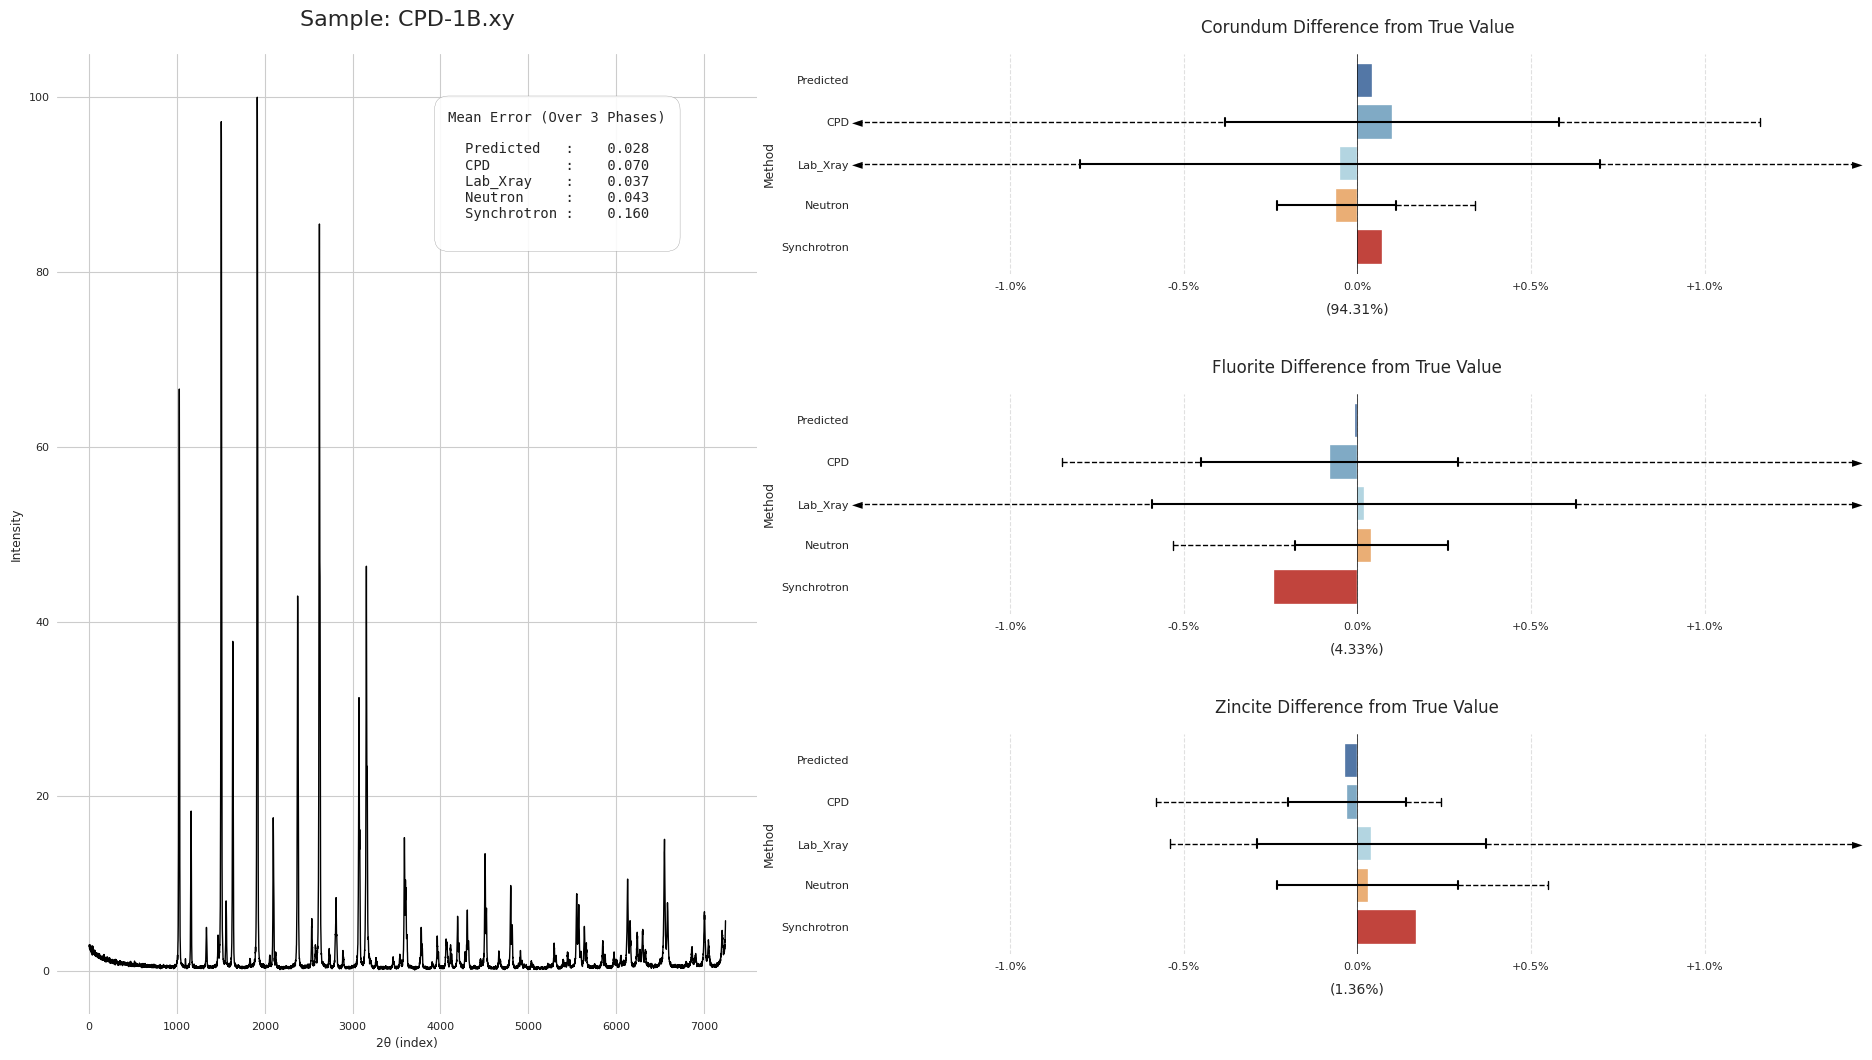

/tmp/ipykernel_138326/696987687.py:266: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x='', y='Method', data=df, ax=ax_phase,
/tmp/ipykernel_138326/696987687.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)
/tmp/ipykernel_138326/696987687.py:266: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x='', y='Method', data=df, ax=ax_phase,
/tmp/ipykernel_138326/696987687.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)
/tmp/ipykernel_138326/696987687.py:266: 

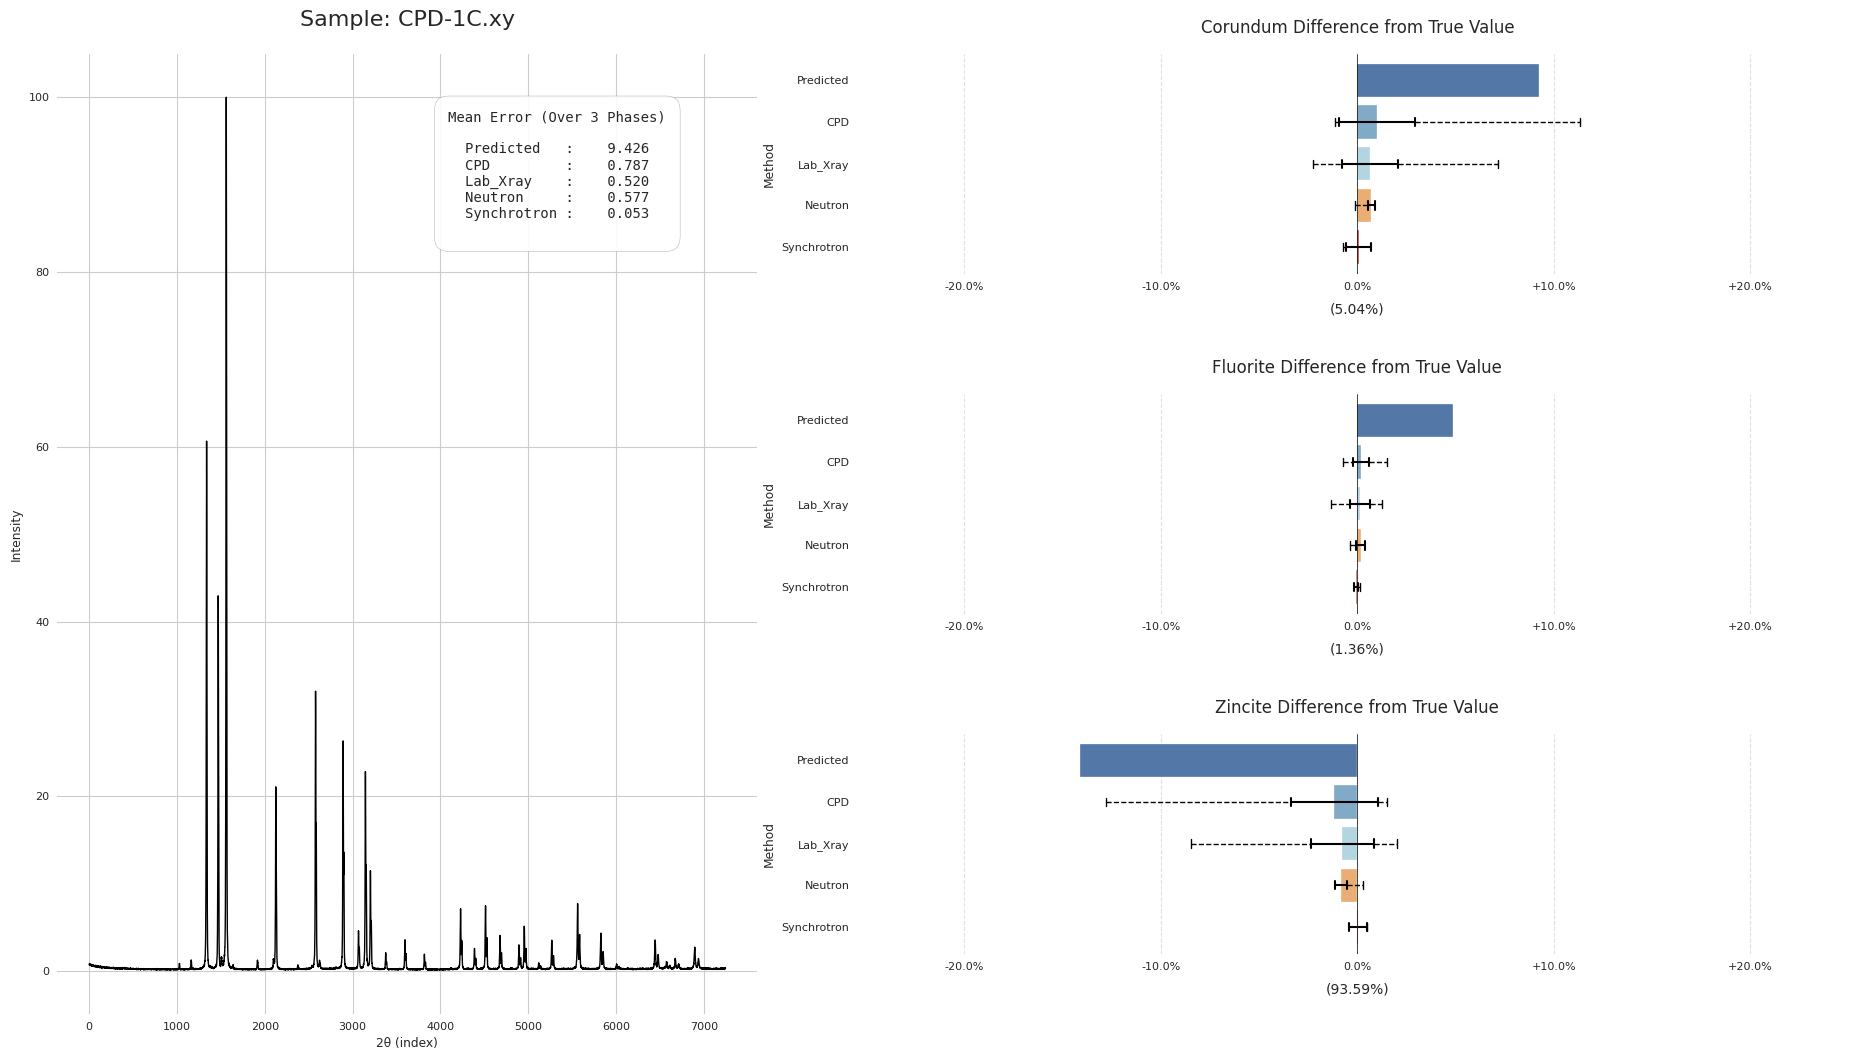

/tmp/ipykernel_138326/696987687.py:266: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x='', y='Method', data=df, ax=ax_phase,
/tmp/ipykernel_138326/696987687.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)
/tmp/ipykernel_138326/696987687.py:266: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x='', y='Method', data=df, ax=ax_phase,
/tmp/ipykernel_138326/696987687.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)
/tmp/ipykernel_138326/696987687.py:266: 

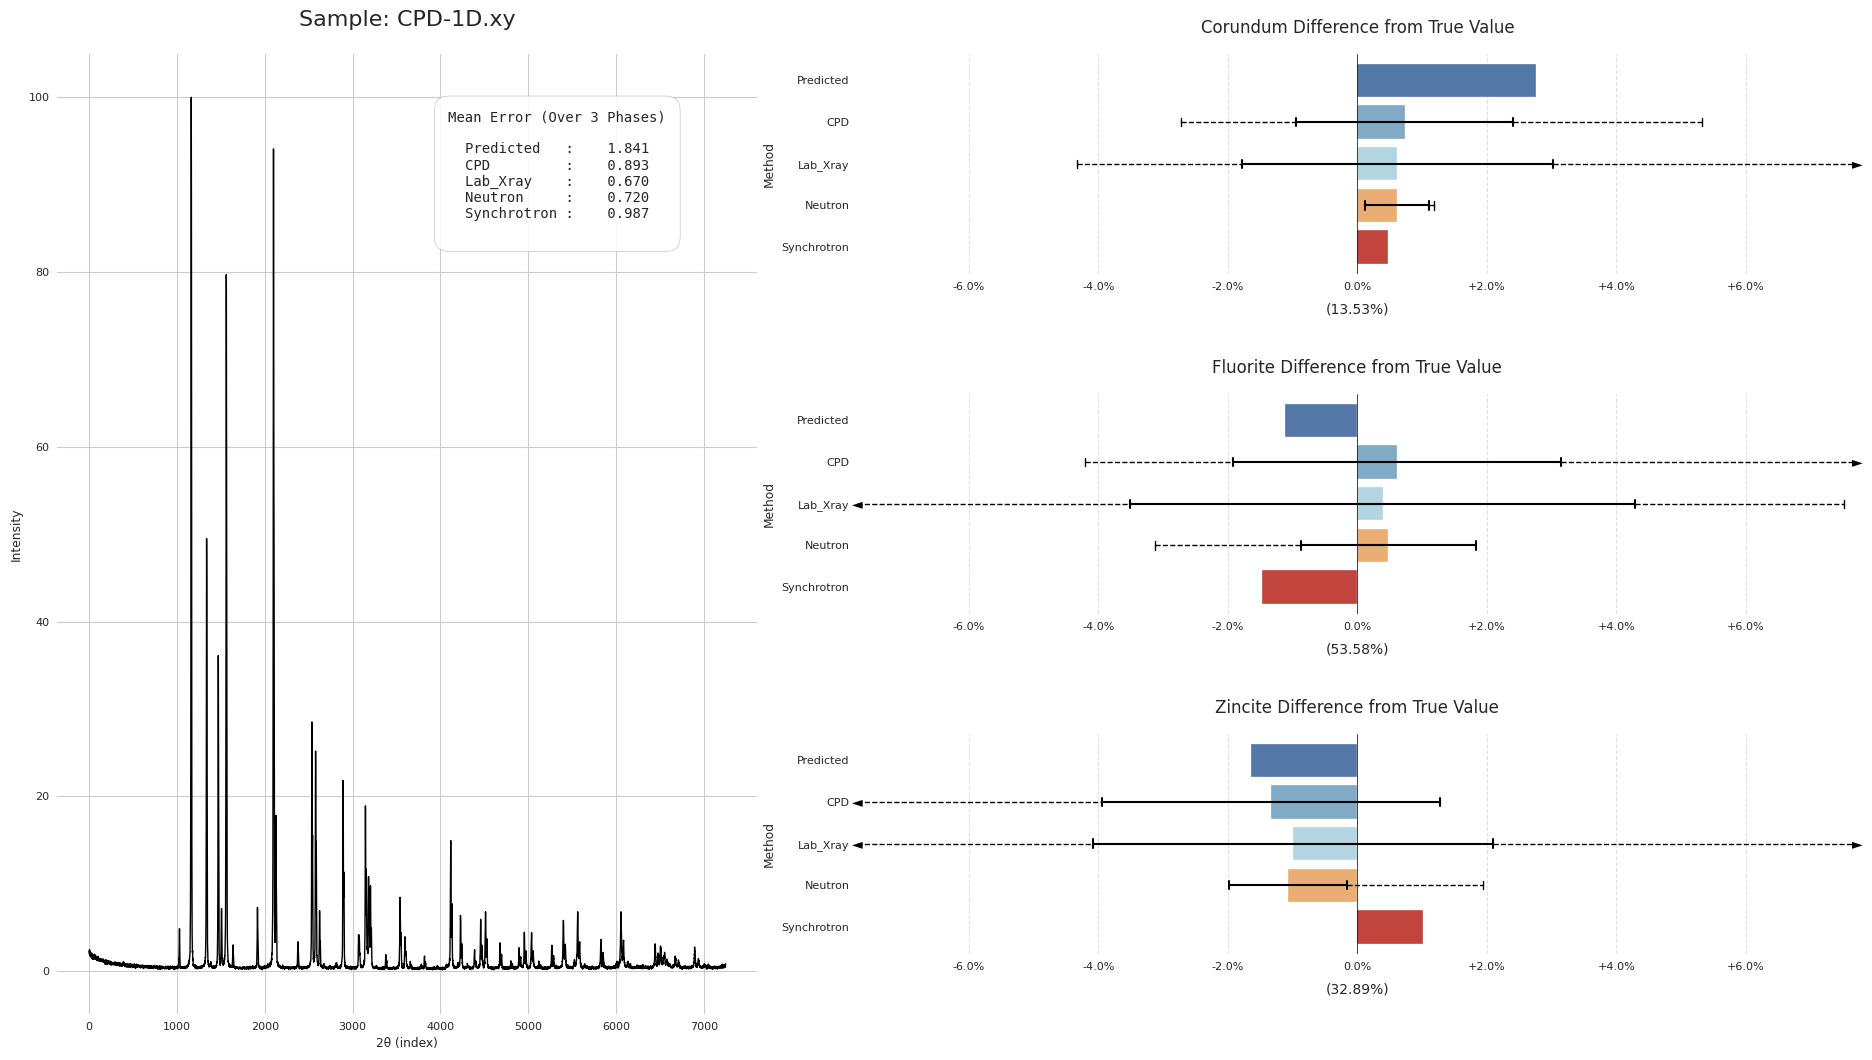

/tmp/ipykernel_138326/696987687.py:266: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x='', y='Method', data=df, ax=ax_phase,
/tmp/ipykernel_138326/696987687.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)
/tmp/ipykernel_138326/696987687.py:266: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x='', y='Method', data=df, ax=ax_phase,
/tmp/ipykernel_138326/696987687.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)
/tmp/ipykernel_138326/696987687.py:266: 

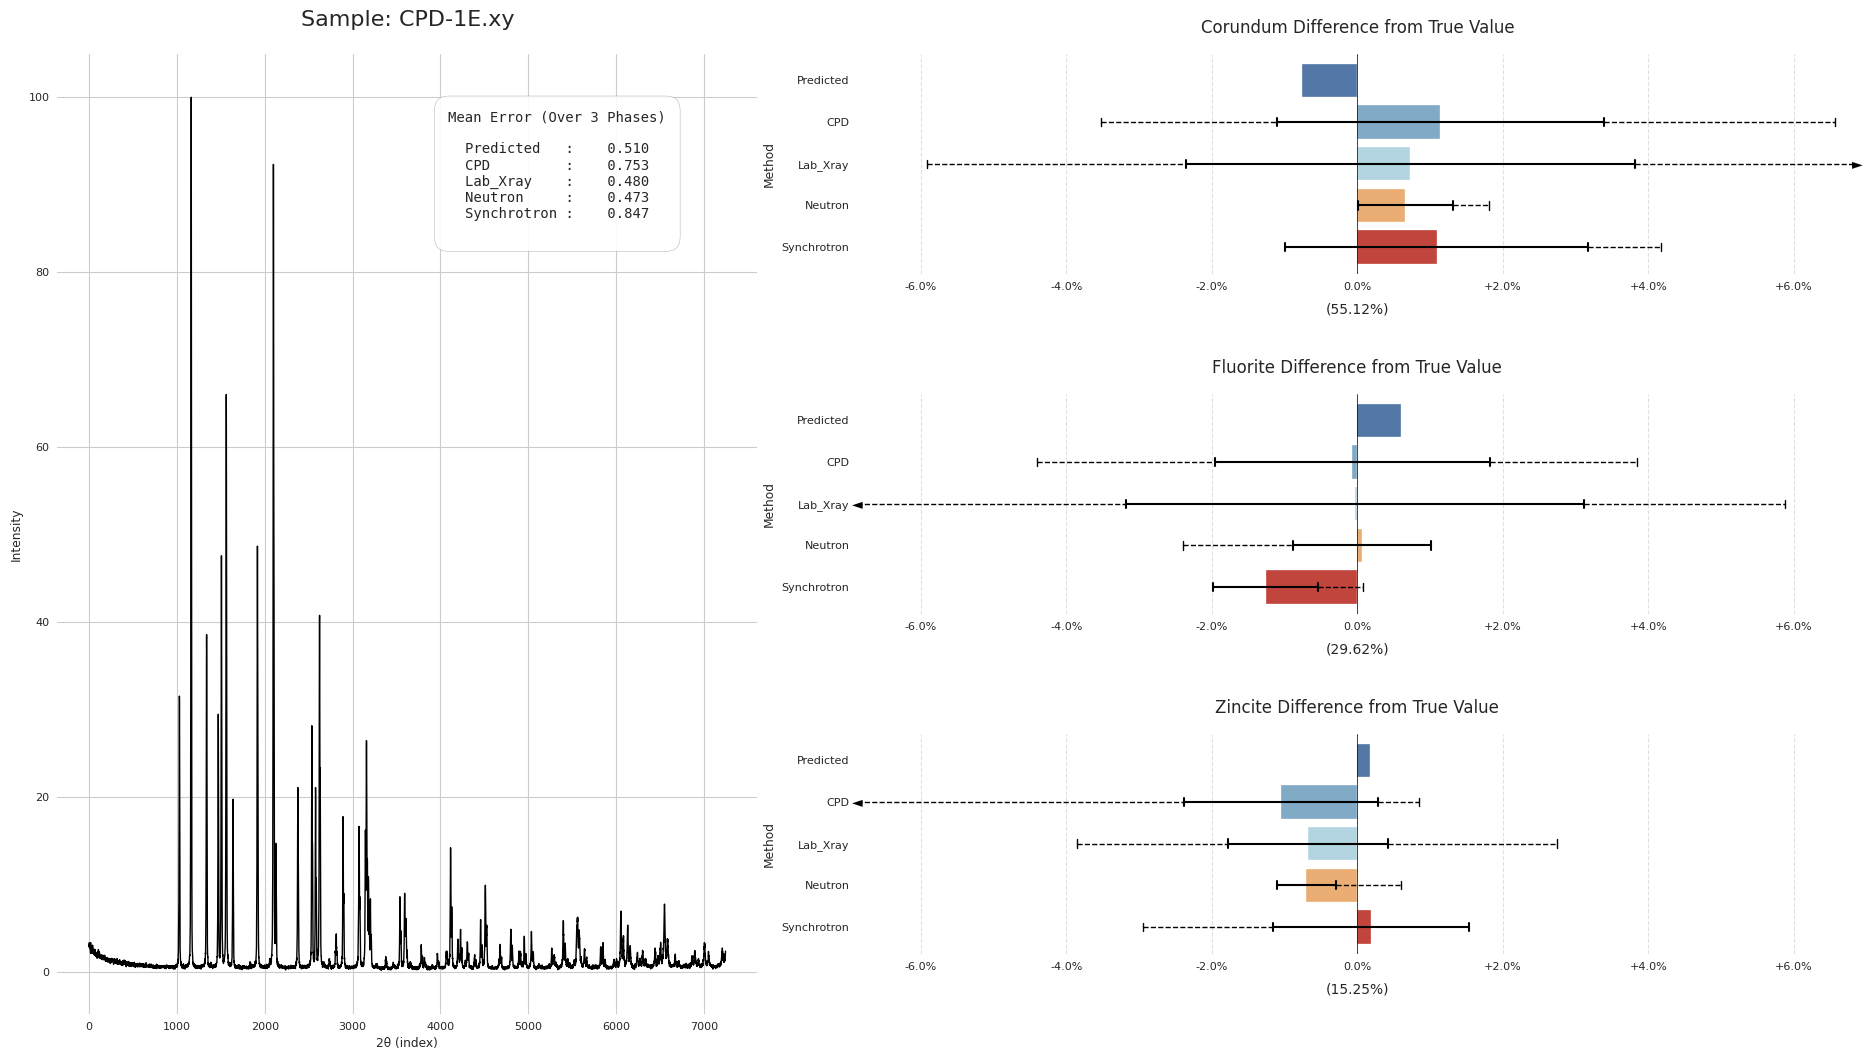

/tmp/ipykernel_138326/696987687.py:266: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x='', y='Method', data=df, ax=ax_phase,
/tmp/ipykernel_138326/696987687.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)
/tmp/ipykernel_138326/696987687.py:266: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x='', y='Method', data=df, ax=ax_phase,
/tmp/ipykernel_138326/696987687.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)
/tmp/ipykernel_138326/696987687.py:266: 

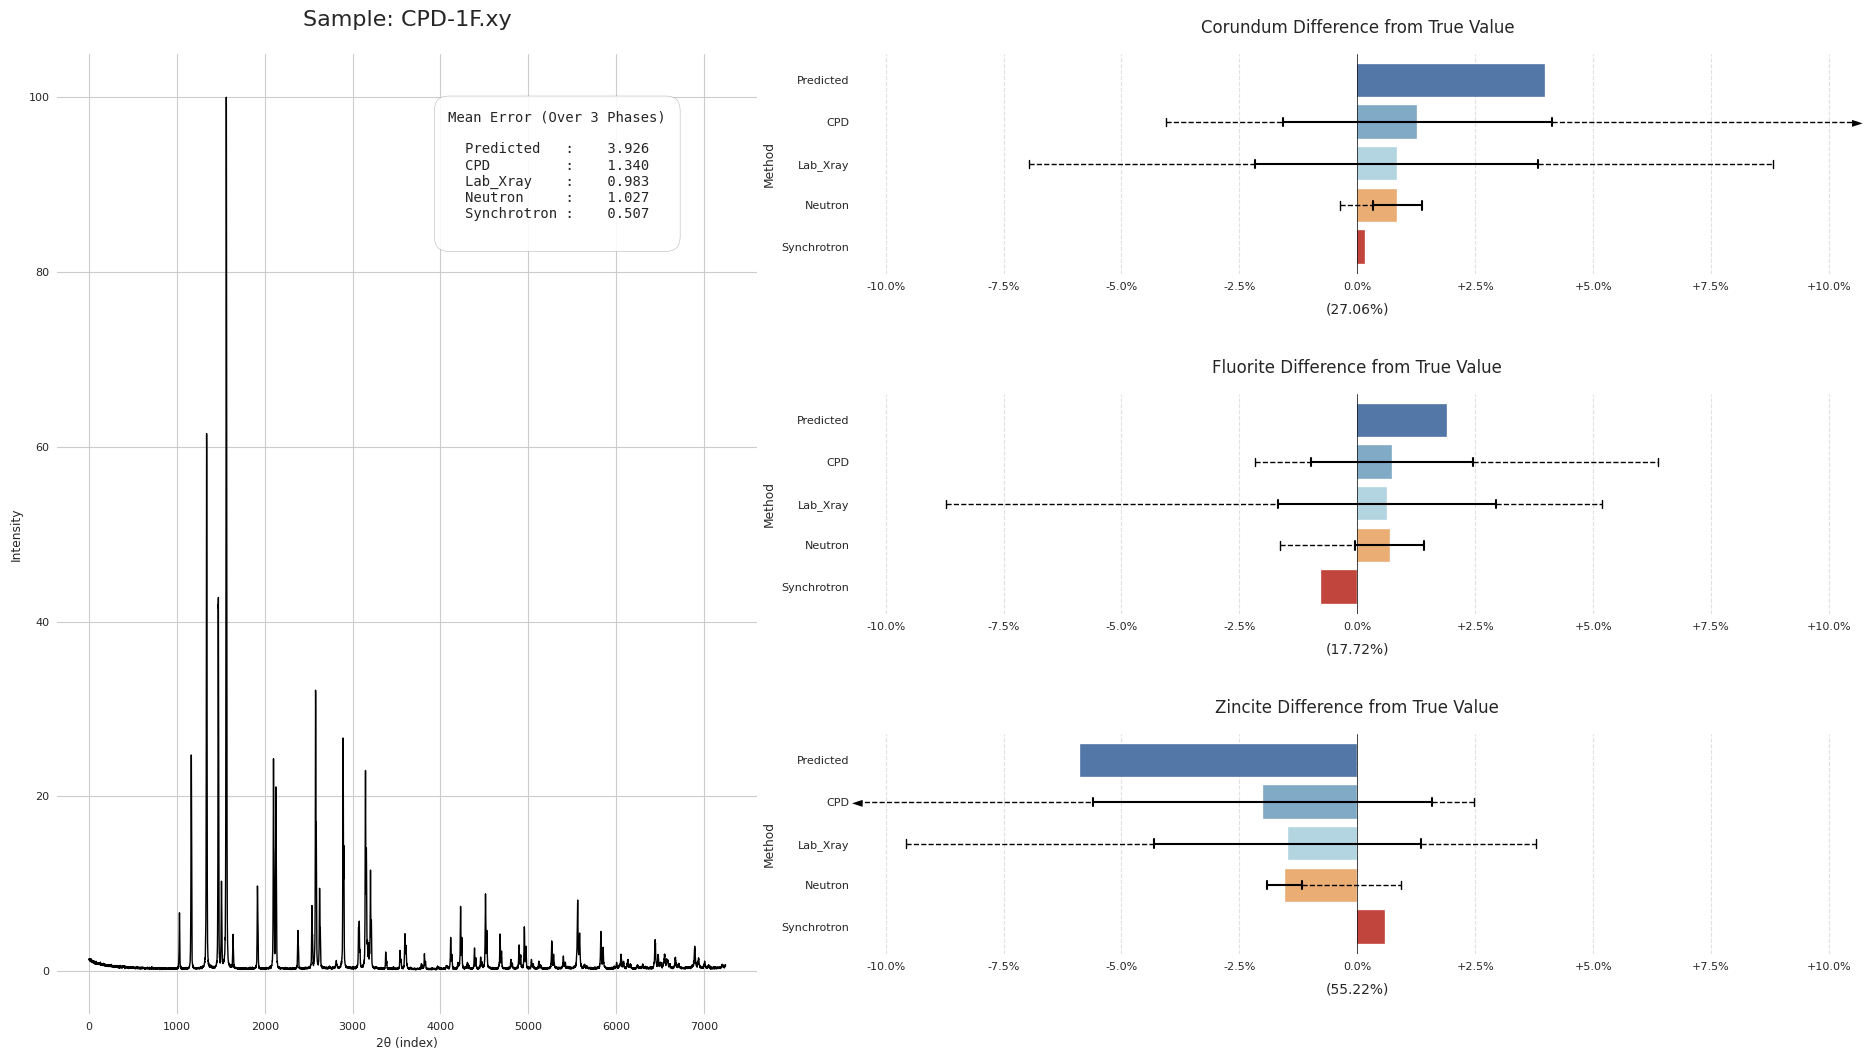

/tmp/ipykernel_138326/696987687.py:266: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x='', y='Method', data=df, ax=ax_phase,
/tmp/ipykernel_138326/696987687.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)
/tmp/ipykernel_138326/696987687.py:266: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x='', y='Method', data=df, ax=ax_phase,
/tmp/ipykernel_138326/696987687.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)
/tmp/ipykernel_138326/696987687.py:266: 

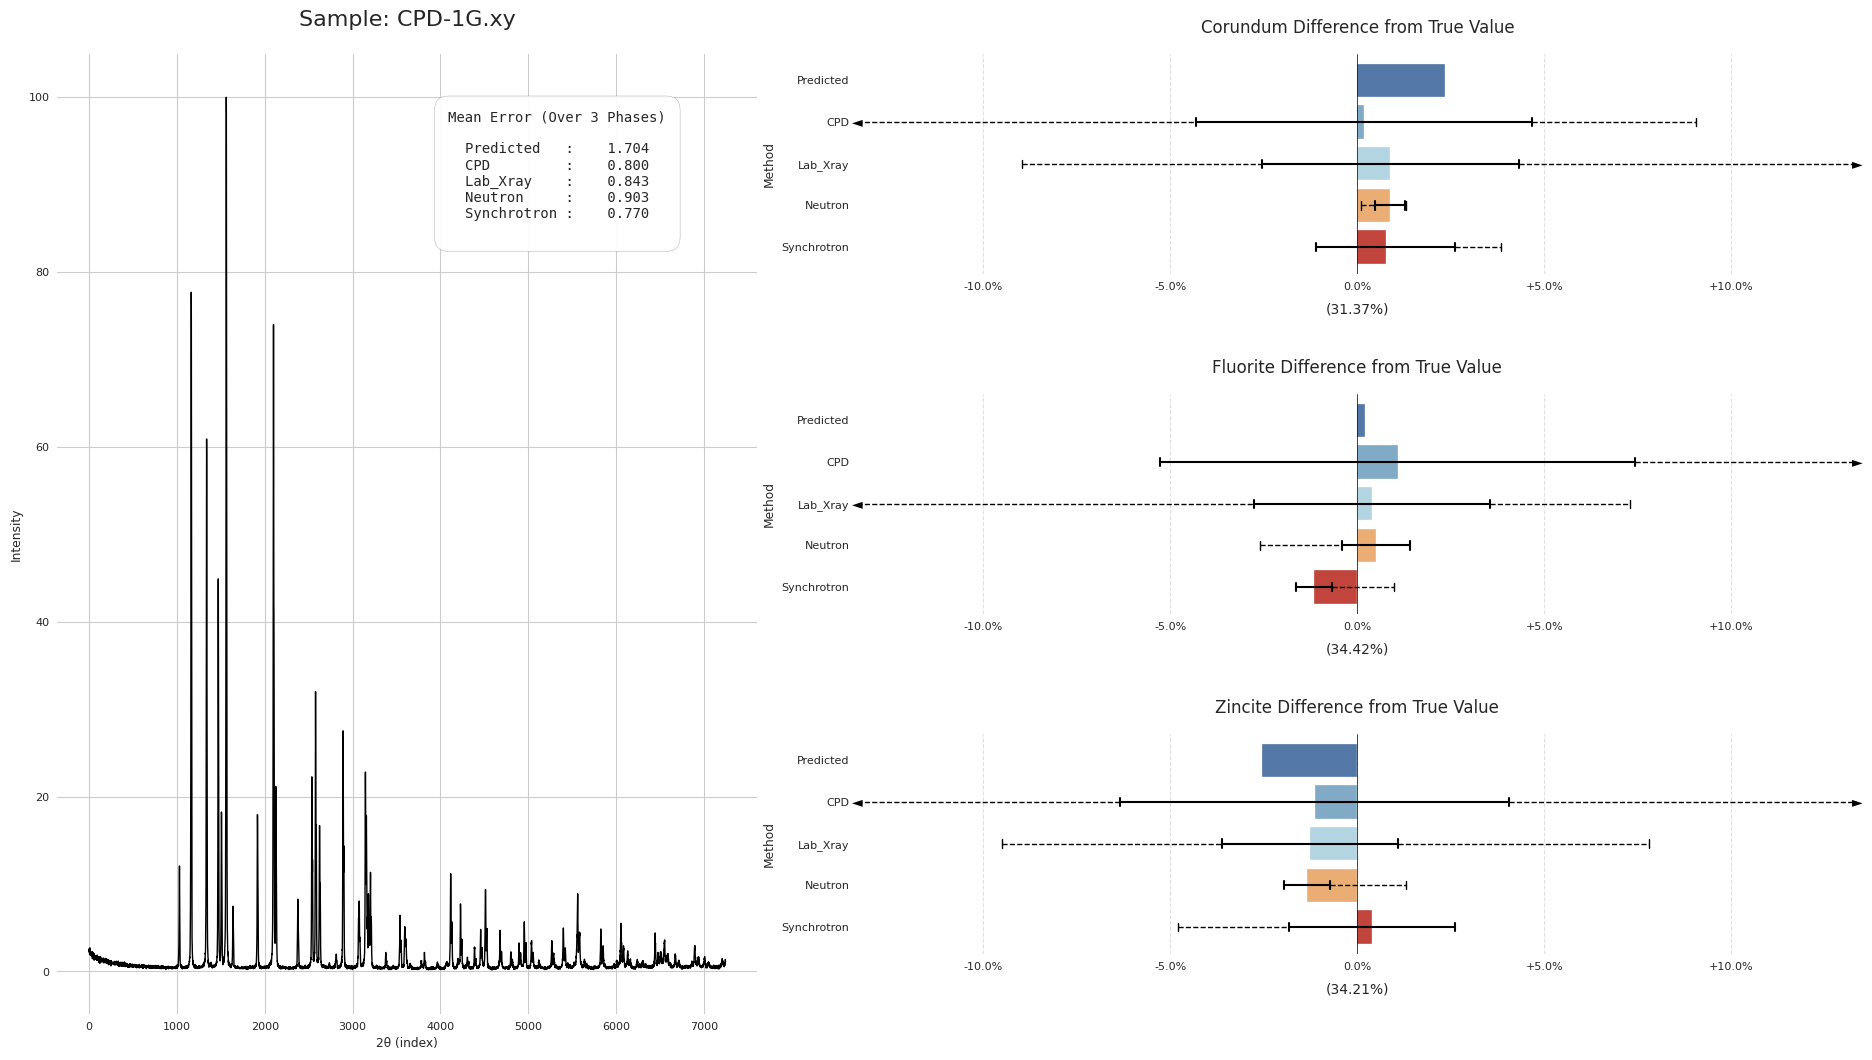

/tmp/ipykernel_138326/696987687.py:266: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x='', y='Method', data=df, ax=ax_phase,
/tmp/ipykernel_138326/696987687.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)
/tmp/ipykernel_138326/696987687.py:266: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x='', y='Method', data=df, ax=ax_phase,
/tmp/ipykernel_138326/696987687.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)
/tmp/ipykernel_138326/696987687.py:266: 

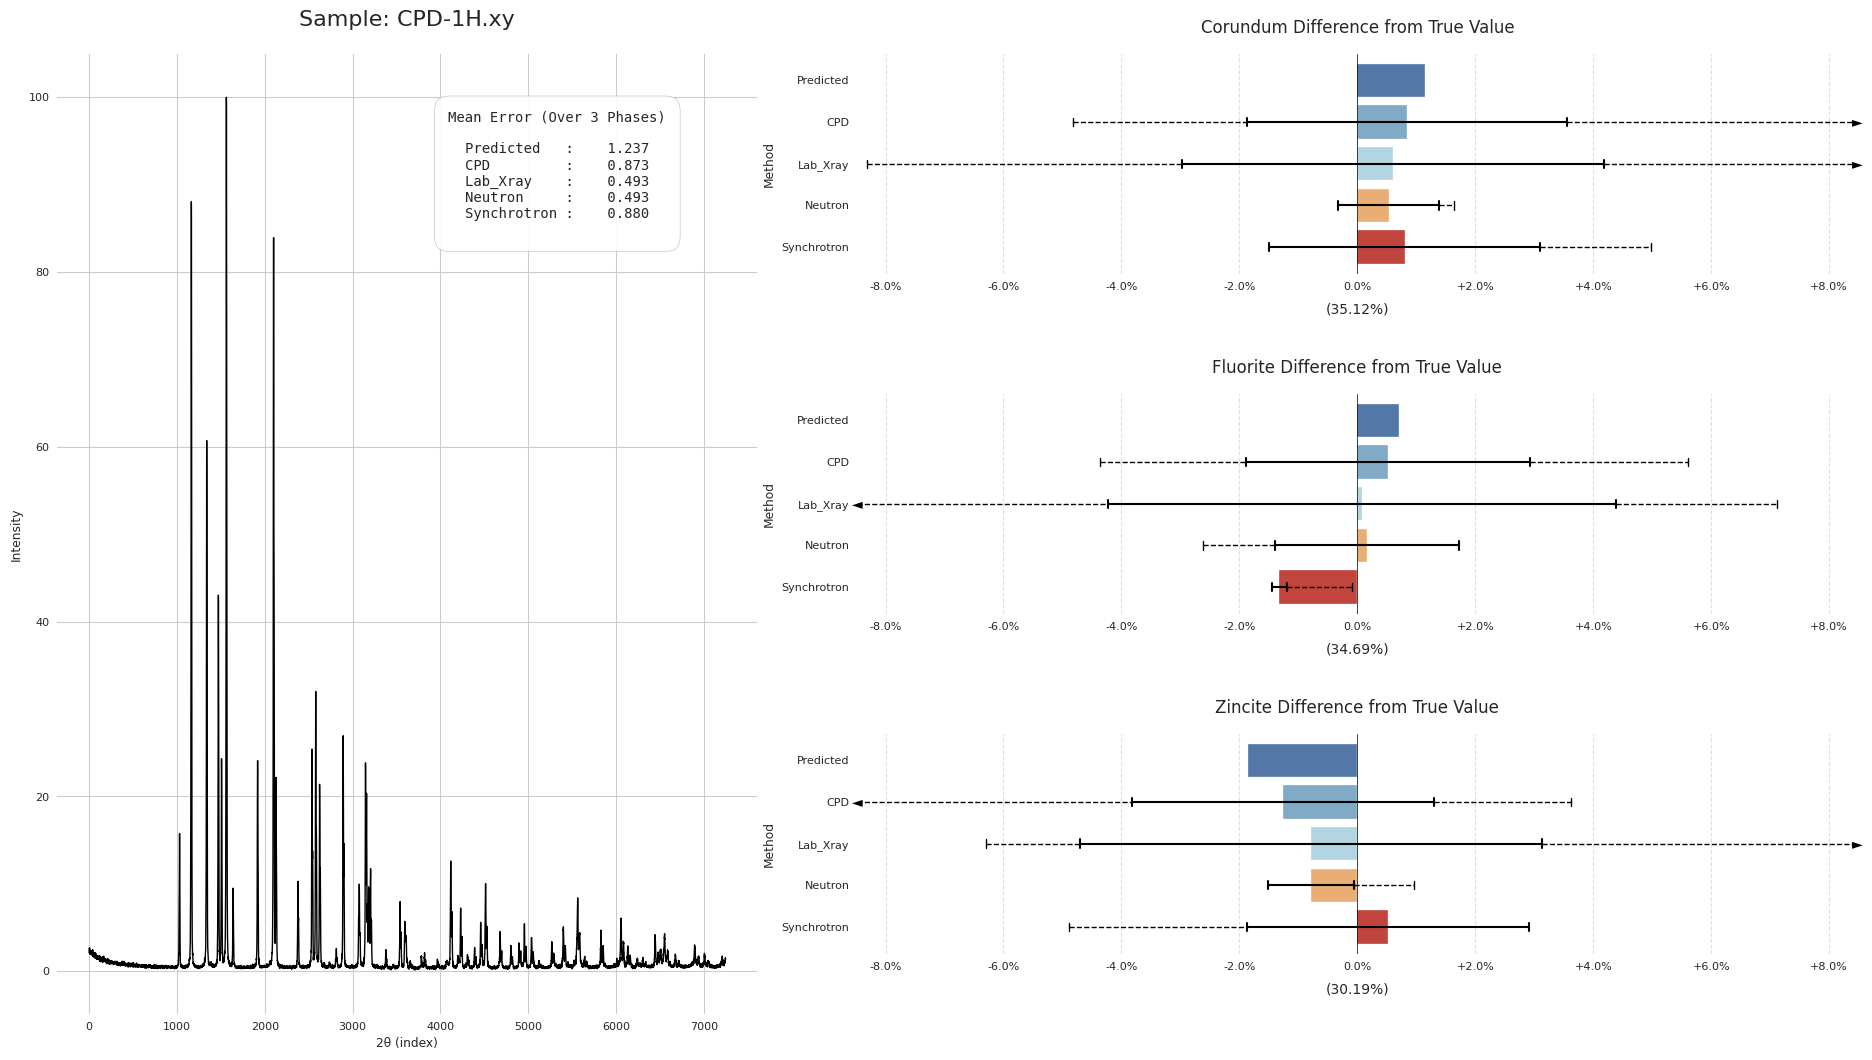

IndexError: list index out of range

In [ ]:
def plot_xrd_patterns_differences(intensities, file_names, predictions, weight_fractions, stats_df, num_plots=11, min_range=5):
    """
    Plot XRD patterns with differences from true values, with improved error bars and stats.
    """
    # Color scheme for differences using a diverging palette
    color_scheme = {
        'Predicted': '#4575b4',      
        'CPD': '#74add1',           # Changed from CPD_analysis
        'Lab_Xray': '#abd9e9',      # Changed from X-ray
        'Neutron': '#fdae61',       
        'Synchrotron': '#d73027'    
    }
    
    def format_x_tick_labels(ax):
        # Add plus signs to positive values
        ticks = ax.get_xticks()
        labels = [f"+{x:.1f}%" if x > 0 else f"{x:.1f}%" for x in ticks]
        ax.set_xticklabels(labels)
    
    def calculate_phase_limits(df, stats_df, phase, sample, true_value, color_scheme, min_range):
        all_base_diffs = []
        sd_limits = []
        
        for method, color in color_scheme.items():
            base_diff = df[df['Method'] == method][''].values[0]
            all_base_diffs.append(base_diff)
            
            if method != 'Predicted':
                stats_rows = stats_df[(stats_df['phase'] == phase) & 
                                (stats_df['method'] == method) &
                                (stats_df['sample'] == sample)]
                
                if len(stats_rows) > 0:
                    stats = stats_rows.iloc[0]
                    if pd.notna(stats['sd']):
                        sd_limits.extend([base_diff - stats['sd'], base_diff + stats['sd']])
        
        if sd_limits or all_base_diffs:
            max_abs_limit = max(
                max(abs(min(all_base_diffs)), abs(max(all_base_diffs))),
                max(abs(min(sd_limits)), abs(max(sd_limits))) if sd_limits else 0
            )
            limit = max(min_range, max_abs_limit * 1.8)
            return limit
        return min_range

    def add_error_bars(ax, bars, df, phase, sample, y_positions, true_value, limit=None):
        if limit is None:
            all_base_diffs = []
            sd_limits = []

            for idx, (method, color) in enumerate(color_scheme.items()):
                base_diff = df[df['Method'] == method][''].values[0]
                all_base_diffs.append(base_diff)
                
                if method != 'Predicted':
                    stats_rows = stats_df[(stats_df['phase'] == phase) & 
                                    (stats_df['method'] == method) &
                                    (stats_df['sample'] == sample)]
                    
                    if len(stats_rows) == 0:
                        continue
                        
                    stats = stats_rows.iloc[0]
                    if pd.notna(stats['sd']):
                        sd_limits.extend([base_diff - stats['sd'], base_diff + stats['sd']])

            if sd_limits or all_base_diffs:
                max_abs_limit = max(
                    max(abs(min(all_base_diffs)), abs(max(all_base_diffs))),
                    max(abs(min(sd_limits)), abs(max(sd_limits))) if sd_limits else 0
                )
                limit = max(min_range, max_abs_limit * 1.8)
        
        ax.set_xlim(-limit, limit)
        
        for idx, (method, color) in enumerate(color_scheme.items()):
            if method == 'Predicted':
                continue
                
            stats_rows = stats_df[(stats_df['phase'] == phase) & 
                            (stats_df['method'] == method) &
                            (stats_df['sample'] == sample)]
            
            if len(stats_rows) == 0:
                continue
                
            stats = stats_rows.iloc[0]
            base_diff = df[df['Method'] == method][''].values[0]
            
            cap_height = 0.2
            if pd.notna(stats['sd']) and pd.notna(stats['min']) and pd.notna(stats['max']):
                min_diff = stats['min'] - (true_value * 100)
                max_diff = stats['max'] - (true_value * 100)
                sd_left = base_diff - stats['sd']
                sd_right = base_diff + stats['sd']
                
                ax.plot([base_diff - stats['sd'], base_diff + stats['sd']], 
                        [y_positions[idx], y_positions[idx]],
                        color='black', linewidth=1.5, zorder=3)
                ax.plot([base_diff - stats['sd'], base_diff - stats['sd']], 
                        [y_positions[idx] - cap_height/2, y_positions[idx] + cap_height/2],
                        color='black', linewidth=1.5, zorder=3)
                ax.plot([base_diff + stats['sd'], base_diff + stats['sd']], 
                        [y_positions[idx] - cap_height/2, y_positions[idx] + cap_height/2],
                        color='black', linewidth=1.5, zorder=3)
                
                whisker_offset = 0.0
                
# Replace the whisker plotting sections with this:
                if min_diff < sd_left:
                    # Draw whisker line up to limit
                    ax.plot([max(min_diff, -limit), sd_left], 
                            [y_positions[idx] + whisker_offset, y_positions[idx] + whisker_offset],
                            color='black', linewidth=1, linestyle='--', zorder=2)
                    
                    # Just arrowhead pointing left if truncated
                    if min_diff < -limit:
                        ax.annotate('◄', xy=(-limit, y_positions[idx] + whisker_offset),
                                  ha='center', va='center', 
                                  color='black',
                                  annotation_clip=False)
                    else:
                        # Regular cap if not truncated
                        ax.plot([min_diff, min_diff], 
                              [y_positions[idx] + whisker_offset - cap_height/2, 
                               y_positions[idx] + whisker_offset + cap_height/2],
                              color='black', linewidth=1, zorder=2)
                
                if max_diff > sd_right:
                    # Draw whisker line up to limit
                    ax.plot([sd_right, min(max_diff, limit)], 
                            [y_positions[idx] + whisker_offset, y_positions[idx] + whisker_offset],
                            color='black', linewidth=1, linestyle='--', zorder=2)
                    
                    # Just arrowhead pointing right if truncated
                    if max_diff > limit:
                        ax.annotate('►', xy=(limit, y_positions[idx] + whisker_offset),
                                  ha='center', va='center',
                                  color='black',
                                  annotation_clip=False)
                    else:
                        # Regular cap if not truncated
                        ax.plot([max_diff, max_diff], 
                              [y_positions[idx] + whisker_offset - cap_height/2, 
                               y_positions[idx] + whisker_offset + cap_height/2],
                              color='black', linewidth=1, zorder=2)

    plot_order = list(range(1, min(num_plots, len(intensities)))) + [0]
    
    for i, idx in enumerate(plot_order):
        sample = file_names[idx].split('-')[1].lower().replace('.xy','')
        
        fig = plt.figure(figsize=(20, 12))
        
        ax_xrd = fig.add_axes([0.1, 0.1, 0.35, 0.8])      # Reduced from 0.5 to 0.35
        ax_phases = fig.add_axes([0.5, 0.1, 0.5, 0.8])   # Start right after XRD ends (0.45) and take up remaining space
        
        ax_xrd.plot(intensities[idx][0], color='black', linewidth=1)
        ax_xrd.set_title(f'Sample: {file_names[idx]}', fontsize=16, pad=20)
        ax_xrd.set_xlabel('2θ (index)')
        ax_xrd.set_ylabel('Intensity')
        
        ax_phases.axis('off')
        
        true_values = weight_fractions.iloc[idx].values
        mse_scores = {
            'Predicted': cum_error(true_values, predictions[idx]),
            'CPD': cum_error(true_values, participant_data['CPD_analysis'].iloc[idx].values),
            'Lab_Xray': cum_error(true_values, participant_data['X-ray'].iloc[idx].values),
            'Neutron': cum_error(true_values, participant_data['Neutron'].iloc[idx].values),
            'Synchrotron': cum_error(true_values, participant_data['Synchrotron'].iloc[idx].values)
        }
        
        mse_text = "Mean Error % (Over 3 Phases)\n\n"
        # Find the longest method name to determine padding
        max_length = max(len(method) for method in mse_scores)
        for method, score in mse_scores.items():
            # Format with consistent spacing and alignment
            mse_text += f"{method:<{max_length}} : {score:>8.3f}\n"

        fig.text(0.35, 0.8, mse_text,
                bbox=dict(facecolor='white', alpha=0.9, edgecolor='gray', 
                        boxstyle='round,pad=1', zorder=1000),
                fontsize=10, va='center', ha='center',
                transform=fig.transFigure,
                zorder=1000,
                family='monospace')
        
        is_single_phase = np.any(np.isclose(true_values, 1.0))
        
        if is_single_phase:
            phase_idx = np.argmax(true_values)
            phase = weight_fractions.columns[phase_idx]
            
            ax_phase = fig.add_axes([0.5, 0.3, 0.5, 0.4])
            
            true_value = weight_fractions.iloc[idx][phase]
            data = {
                'Predicted': (predictions[idx][phase_idx] - true_value) * 100,
                'CPD': (participant_data['CPD_analysis'].iloc[idx][phase] - true_value) * 100,
                'Lab_Xray': (participant_data['X-ray'].iloc[idx][phase] - true_value) * 100,
                'Neutron': (participant_data['Neutron'].iloc[idx][phase] - true_value) * 100,
                'Synchrotron': (participant_data['Synchrotron'].iloc[idx][phase] - true_value) * 100
            }
            
            df = pd.DataFrame(list(data.items()), columns=['Method', ''])
            
            bars = sns.barplot(x='', y='Method', data=df, ax=ax_phase, 
                             palette=color_scheme, orient='h', legend=False)
            
            y_positions = np.arange(len(df))
            add_error_bars(ax_phase, bars, df, phase, sample, y_positions, true_value)
            
            ax_phase.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
            # Add true value label at x-axis zero
            ylim = ax_phase.get_ylim()  # Get current y-axis limits
            ax_phase.text(0, ylim[0] + 0.7, f'({true_value*100:.2f}%)', 
                        ha='center', va='top', fontsize=10)
            
            ax_phase.set_title(f'{phase} Difference from True Value', fontsize=12, pad=15)
            
            ax_phase.grid(True, axis='x', linestyle='--', alpha=0.6)
            format_x_tick_labels(ax_phase)
            
        else:
            num_phases = len(weight_fractions.columns)

            max_limit = min_range
            for phase_idx, phase in enumerate(weight_fractions.columns):
                true_value = weight_fractions.iloc[idx][phase]
                data = {
                    'Predicted': (predictions[idx][phase_idx] - true_value) * 100,
                    'CPD': (participant_data['CPD_analysis'].iloc[idx][phase] - true_value) * 100,
                    'Lab_Xray': (participant_data['X-ray'].iloc[idx][phase] - true_value) * 100,
                    'Neutron': (participant_data['Neutron'].iloc[idx][phase] - true_value) * 100,
                    'Synchrotron': (participant_data['Synchrotron'].iloc[idx][phase] - true_value) * 100
                }
                df = pd.DataFrame(list(data.items()), columns=['Method', ''])
                phase_limit = calculate_phase_limits(df, stats_df, phase, sample, true_value, color_scheme, min_range)
                max_limit = max(max_limit, phase_limit)
            
            total_height = 0.8
            spacing = 0.05
            title_space = 0.05
            available_height = total_height - (spacing * (num_phases - 1)) - (title_space * num_phases)
            phase_height = available_height / num_phases
            
            for j, phase in enumerate(weight_fractions.columns):
                top = 0.9 - (j * (phase_height + spacing + title_space))
                bottom = top - phase_height
                
                ax_phase = fig.add_axes([0.5, bottom, 0.5, phase_height])
                
                true_value = weight_fractions.iloc[idx][phase]
                data = {
                    'Predicted': (predictions[idx][j] - true_value) * 100,
                    'CPD': (participant_data['CPD_analysis'].iloc[idx][phase] - true_value) * 100,
                    'Lab_Xray': (participant_data['X-ray'].iloc[idx][phase] - true_value) * 100,
                    'Neutron': (participant_data['Neutron'].iloc[idx][phase] - true_value) * 100,
                    'Synchrotron': (participant_data['Synchrotron'].iloc[idx][phase] - true_value) * 100
                }
                
                df = pd.DataFrame(list(data.items()), columns=['Method', ''])
                
                bars = sns.barplot(x='', y='Method', data=df, ax=ax_phase, 
                                 palette=color_scheme, orient='h', legend=False)
                
                y_positions = np.arange(len(df))
                add_error_bars(ax_phase, bars, df, phase, sample, y_positions, true_value, max_limit)
                
                ax_phase.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
                # Add true value label below x-axis at zero
                # Add true value label at x-axis zero
                ylim = ax_phase.get_ylim()  # Get current y-axis limits
                ax_phase.text(0, ylim[0] + 0.7, f'({true_value*100:.2f}%)', 
                            ha='center', va='top', fontsize=10)             
                ax_phase.set_title(f'{phase} Difference from True Value', fontsize=12, pad=15)
                
                ax_phase.grid(True, axis='x', linestyle='--', alpha=0.6)
                ax_phase.tick_params(axis='y', labelsize=8)
                format_x_tick_labels(ax_phase)
                
        plt.show()
        plt.close()

# Call the plotting function
plot_xrd_patterns_differences(intensities, xy_files, predictions, weight_fractions, stats_df, min_range=1)